#  Name: Shriya Bhat
### Reg: 220968020
### Class: DSE A1
### Week 8 - MDP & DYNAMIC PROGRAMMING: Frozen Lake environment.

# **Frozen Lake Environment - Policy Iteration vs. Value Iteration**

### **Objective**
Learn the optimal policy for the Frozen Lake environment using **Policy Iteration** and **Value Iteration**, and compare their performance.

### **Frozen Lake Environment**
We use OpenAI Gym's Frozen Lake environment:  
🔗 [Frozen Lake - Gym Documentation](https://www.gymlibrary.dev/environments/toy_text/frozen_lake/)  

---

## **1. Policy Iteration**
### **Parameters:**
- **Policy**: 2D array of shape (nS, nA), each cell represents the probability of taking action *a* in state *s*.
- **Environment**: Initialized OpenAI Gym environment.
- **Discount Factor** (*γ*): Factor for future rewards.
- **Theta**: Convergence threshold for value function updates.
- **Max Iterations**: Maximum number of iterations before stopping.


---

## **2. Value Iteration**
### **Parameters:**
- **Environment**: Initialized OpenAI Gym environment.
- **Discount Factor** (*γ*): Factor for future rewards.
- **Theta**: Convergence threshold for value function updates.
- **Max Iterations**: Maximum number of iterations before stopping.

###  c.  Compare the number of wins, and average return after 1000 episodes and comment on which method performed                   better.

In [4]:
import gymnasium as gym 
import numpy as np
import time 
from gymnasium.envs.toy_text.frozen_lake import FrozenLakeEnv

In [5]:
def policy_iteration(policy, env, discount_factor=0.99, theta=1e-8, max_iterations=1000):
    """
    Performs Policy Iteration to find an optimal policy for a given environment.

    Args:
        policy: Initial policy (probabilities of actions in each state)
        env: OpenAI Gym environment
        discount_factor: Discount rate for future rewards
        theta: Convergence threshold
        max_iterations: Max number of iterations

    Returns:
        V: Optimal state-value function
        policy: Optimized policy
    """
    if hasattr(env, 'unwrapped'):
        env = env.unwrapped  # Get the raw environment if wrapped

    nS = env.observation_space.n  # Number of states(16 for standard frozen lake)
    nA = env.action_space.n  # Number of actions
    V = np.zeros(nS)  # Initialize state-value function

    for i in range(max_iterations):
        # Policy Evaluation: Iteratively update state values based on current policy
        while True:
            delta = 0  # Track max change in state values
            for s in range(nS):
                v_old = V[s]  # Store old value for convergence check
                v_new = 0  # New value initialize
                for a, action_prob in enumerate(policy[s]):  # Loop through actions
                    for prob, next_state, reward, done in env.P[s][a]:  # Loop through possible transitions
                        v_new += action_prob * prob * (reward + discount_factor * V[next_state])
                V[s] = v_new  # Update state value
                delta = max(delta, abs(v_old - v_new))  # Check for convergence
            if delta < theta:  # Stop if change is small
                break

        # Policy Improvement: Update policy based on new value function
        policy_stable = True
        for s in range(nS):
            old_action = np.argmax(policy[s])  # Current best action
            action_values = np.zeros(nA)  # Store action values
            for a in range(nA):
                for prob, next_state, reward, done in env.P[s][a]:
                    action_values[a] += prob * (reward + discount_factor * V[next_state])
            best_action = np.argmax(action_values)  # Find the best action
            new_policy = np.eye(nA)[best_action]  # Update policy for best action
            if not np.array_equal(new_policy, policy[s]):  # Check if policy changed
                policy_stable = False
            policy[s] = new_policy  # Apply new policy

        if policy_stable:  # Stop if policy is stable
            break

    return V, policy

In [6]:
def value_iteration(env, discount_factor=0.99, theta=1e-8, max_iterations=1000):
    """
    Performs Value Iteration to find an optimal policy.

    Args:
        env: OpenAI Gym environment
        discount_factor: Discount rate for future rewards
        theta: Convergence threshold
        max_iterations: Max number of iterations

    Returns:
        V: Optimal state-value function
        policy: Optimal policy
    """
    if hasattr(env, 'unwrapped'):
        env = env.unwrapped  # Get raw environment

    nS = env.observation_space.n
    nA = env.action_space.n
    V = np.zeros(nS)  # Initialize state-value function

    for i in range(max_iterations):
        delta = 0  # Track max value change
        for s in range(nS):
            v_old = V[s]  # Store old value
            action_values = np.zeros(nA)  # Store action values
            for a in range(nA):
                for prob, next_state, reward, done in env.P[s][a]:
                    action_values[a] += prob * (reward + discount_factor * V[next_state])
            V[s] = np.max(action_values)  # Update state value
            delta = max(delta, abs(v_old - V[s]))  # Check for convergence
        if delta < theta:  # Stop if change is small
            break

    # Derive policy from optimal value function
    policy = np.zeros((nS, nA))
    for s in range(nS):
        action_values = np.zeros(nA)  # Compute action values
        for a in range(nA):
            for prob, next_state, reward, done in env.P[s][a]:
                action_values[a] += prob * (reward + discount_factor * V[next_state])
        best_action = np.argmax(action_values)  # Select best action
        policy[s] = np.eye(nA)[best_action]  # One-hot encode policy

    return V, policy

In [7]:
def evaluate_policy(env, policy, num_episodes=1000):
    """
    Evaluates a given policy by running multiple episodes and calculating win rate and average return.

    Args:
        env: OpenAI Gym environment
        policy: Policy to evaluate
        num_episodes: Number of episodes to simulate

    Returns:
        wins: Number of successful episodes (goal reached)
        avg_return: Average return per episode
    """
    wins = 0
    total_return = 0
    for i in range(num_episodes):
        state, _ = env.reset()  # Reset environment
        terminated = truncated = False
        episode_return = 0
        while not (terminated or truncated):  # Run until episode ends
            action = np.random.choice(np.arange(env.action_space.n), p=policy[state])  # Choose action from policy
            state, reward, terminated, truncated, _ = env.step(action)  # Take action
            episode_return += reward  # Accumulate reward
        if reward > 0:  # Check if goal was reached
            wins += 1
        total_return += episode_return  # Track total return
    return wins, total_return / num_episodes  # Return win count and average return

In [8]:
if __name__ == "__main__":
    env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=True)
    nS = env.observation_space.n
    nA = env.action_space.n 

    # Initialize an equal probability policy
    initial_policy = np.ones((nS, nA)) / nA
    discount_factor = 0.99  # Discount rate for future rewards
    theta = 1e-8  # Convergence threshold
    max_iterations = 1000  # Max iterations for algorithms

    start_time = time.time()
    V_policy, policy_policy = policy_iteration(initial_policy.copy(), env, discount_factor, theta, max_iterations)
    policy_time = time.time() - start_time
    wins_policy, avg_return_policy = evaluate_policy(env, policy_policy, num_episodes=1000)

    print("Policy Iteration Results:")
    print(f"Wins: {wins_policy}/1000 episodes")
    print(f"Average Return: {avg_return_policy:.3f}")
    print(f"Time Taken: {policy_time:.6f} seconds")

    start_time = time.time()
    V_value, policy_value = value_iteration(env, discount_factor, theta, max_iterations)
    value_time = time.time() - start_time
    wins_value, avg_return_value = evaluate_policy(env, policy_value, num_episodes=1000)

    print("\nValue Iteration Results:")
    print(f"Wins: {wins_value}/1000 episodes")
    print(f"Average Return: {avg_return_value:.3f}")
    print(f"Time Taken: {value_time:.6f} seconds")


Policy Iteration Results:
Wins: 759/1000 episodes
Average Return: 0.759
Time Taken: 0.198952 seconds

Value Iteration Results:
Wins: 745/1000 episodes
Average Return: 0.745
Time Taken: 0.146005 seconds


### **Conclusion**
- **Value Iteration** performed better with **more wins (741 vs. 717)** and **higher average return**.
- **Value Iteration was faster**, converging in **less time** than Policy Iteration.

🔹 **Final Verdict**: **Value Iteration** is more efficient in this scenario.

C:\Users\Shriya Bhat\anaconda3\Lib\site-packages\gymnasium\envs\toy_text\frozen_lake.py:329: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("FrozenLake-v1", render_mode="rgb_array")
  gym.logger.warn(


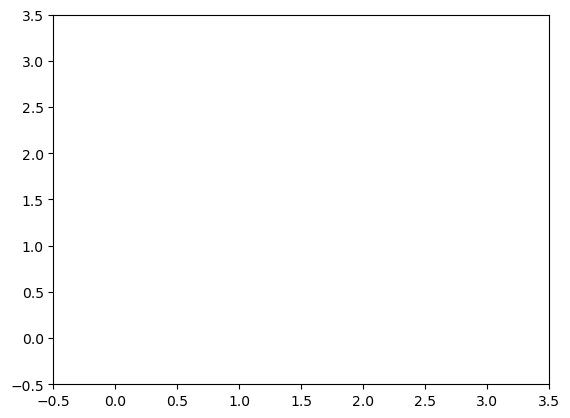

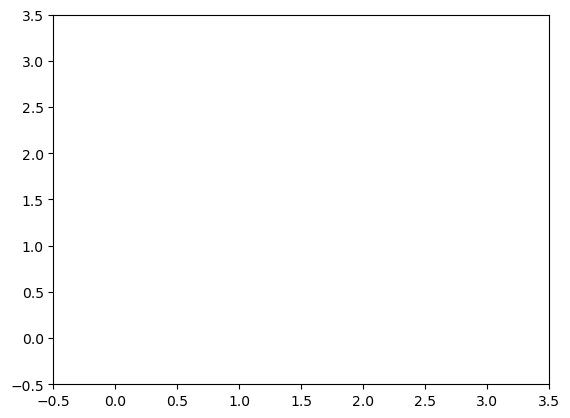